<a href="https://colab.research.google.com/github/Bhat14/PFDS-L08-B-51-/blob/main/Project(Pfds).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
%pip install -U pandas numpy scikit-learn xgboost optuna shap imbalanced-learn joblib

  Using cached numpy-2.3.2-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)


In [38]:
"""
Comprehensive supervised classifier evaluation script
- Auto-extracts zip (if present) and finds the first CSV
- Auto-identifies numeric & categorical cols
- Trains multiple classifiers and prints classification reports + confusion matrices
- Produces cross-validated metrics and Brier score (calibration)
- Saves results to results_summary.csv and models to ./models/

Requirements:
pip install -U pandas numpy scikit-learn xgboost lightgbm catboost imbalanced-learn joblib shap
(you can omit CatBoost/LightGBM/XGBoost if not installed; script will skip them gracefully)
"""

import os
import zipfile
import glob
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, brier_score_loss, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.utils import class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import joblib

# Optional imports - skip if not installed
try:
    import xgboost as xgb
    has_xgb = True
except Exception:
    has_xgb = False

try:
    import lightgbm as lgb
    has_lgb = True
except Exception:
    has_lgb = False

try:
    from catboost import CatBoostClassifier
    has_cat = True
except Exception:
    has_cat = False

# ---------------------------
# User-editable config
# ---------------------------
# If you uploaded a zip, script will attempt to extract and find CSVs.
# !!! IMPORTANT: Replace this path with the actual path to your zip file in Colab !!!
ZIP_PATH = "/content/archive (2).zip"   # <-- change if different, or set DATA_PATH to CSV directly
DATA_PATH = None  # if you already know the CSV path, set it here e.g. "/mnt/data/mydata.csv"
# TARGET_COL = "target"  # <-- change to your label column name # Removed duplicate definition
ID_COL = None  # optional id column to drop if present
RANDOM_STATE = 42
TEST_SIZE = 0.2

# ---------------------------
# Helper functions
# ---------------------------
def find_csv_in_zip(zip_path): # Corrected function definition
    if not os.path.exists(zip_path):
        return None
    extract_dir = os.path.splitext(zip_path)[0] + "_extracted"
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)
    csvs = glob.glob(os.path.join(extract_dir, "**", "*.csv"), recursive=True)
    return csvs[0] if csvs else None

def find_first_csv_in_dir(search_dir="/mnt/data"):
    csvs = glob.glob(os.path.join(search_dir, "**", "*.csv"), recursive=True)
    return csvs[0] if csvs else None

def automatic_feature_split(df, target_col, id_col=None, max_unique_for_cat=20):
    if id_col and id_col in df.columns:
        df = df.drop(columns=[id_col])
    y = df[target_col].copy()
    X = df.drop(columns=[target_col])
    numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    # Convert low-unique numerics to categorical
    for col in numeric_cols[:]:
        if X[col].nunique() <= max_unique_for_cat:
            numeric_cols.remove(col)
            categorical_cols.append(col)
    return X, y, numeric_cols, categorical_cols

def build_preprocessor(numeric_cols, categorical_cols):
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore")) # Removed sparse=False
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ], remainder="drop")
    return preprocessor

# ---------------------------
# Main routine
# ---------------------------
def main():
    global DATA_PATH
    # Ensure TARGET_COL is set correctly within main
    TARGET_COL = "approval_status" # Ensure the correct target column is used here

    # locate dataset
    if DATA_PATH is None:
        # try csv in zip
        csv_path = find_csv_in_zip(ZIP_PATH)
        if csv_path:
            print(f"Found CSV inside zip: {csv_path}")
            DATA_PATH = csv_path
        else:
            csv_path = find_first_csv_in_dir("/mnt/data")
            if csv_path:
                print(f"Found CSV in /mnt/data: {csv_path}")
                DATA_PATH = csv_path
            else:
                raise FileNotFoundError("No CSV found. Set DATA_PATH or place CSV under /mnt/data")

    print("Using dataset:", DATA_PATH)
    df = pd.read_csv(DATA_PATH)
    print("Dataset shape:", df.shape)
    if TARGET_COL not in df.columns:
        raise ValueError(f"Target column '{TARGET_COL}' not found. Columns: {df.columns.tolist()[:50]}")

    X, y, numeric_cols, categorical_cols = automatic_feature_split(df, TARGET_COL, ID_COL)
    print("Numeric cols:", numeric_cols)
    print("Categorical cols:", categorical_cols)

    preprocessor = build_preprocessor(numeric_cols, categorical_cols)

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # Encode target variable to integers for models that require it (like XGBoost in multi-class)
    y_train = y_train.astype('category').cat.codes
    y_test = y_test.astype('category').cat.codes

    # handle class weights for imbalanced problems in some models
    classes = np.unique(y_train)
    is_binary = (len(classes) == 2)

    # Prepare models dictionary
    models = {}

    # Classic sklearn models
    models["LogisticRegression"] = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)
    models["RandomForest"] = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE, n_jobs=-1)
    models["GradientBoosting"] = GradientBoostingClassifier(n_estimators=300, random_state=RANDOM_STATE)
    models["KNN"] = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    models["SVM-rbf"] = SVC(probability=True, random_state=RANDOM_STATE)
    models["GaussianNB"] = GaussianNB()

    if has_xgb:
        # For binary classification
        try:
            models["XGBoost"] = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1)
        except Exception:
            models["XGBoost"] = xgb.XGBClassifier(n_estimators=500, random_state=RANDOM_STATE)
    if has_lgb:
        models["LightGBM"] = lgb.LGBMClassifier(n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1)
    if has_cat:
        models["CatBoost"] = CatBoostClassifier(verbose=0, random_state=RANDOM_STATE)

    # result storage
    results = []

    # create models dir
    os.makedirs("models", exist_ok=True)

    # cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    for name, estimator in models.items():
        print("\n" + "="*60)
        print(f"Training & evaluating: {name}")
        # build pipeline
        pipeline = Pipeline([
            ("preprocessor", preprocessor),
            ("clf", estimator)
        ])

        # Apply preprocessing separately to handle sparse/dense requirements per model
        X_train_processed = pipeline.named_steps['preprocessor'].fit_transform(X_train)
        X_test_processed = pipeline.named_steps['preprocessor'].transform(X_test)

        # Convert to dense if required by the model
        if isinstance(estimator, (GaussianNB, SVC)): # Add other dense-requiring models if needed
             if hasattr(X_train_processed, 'toarray'):
                  X_train_processed = X_train_processed.toarray()
             if hasattr(X_test_processed, 'toarray'):
                  X_test_processed = X_test_processed.toarray()


        # Fit on training set using the (potentially dense) processed data
        pipeline.named_steps['clf'].fit(X_train_processed, y_train)

        # Save fitted pipeline (this will save the whole pipeline including preprocessor and fitted classifier)
        # Note: If you need to save the calibrator too, you would wrap the classifier pipeline in CalibratedClassifierCV
        # as done in the explainability script, and save that wrapper. For this general evaluation, we save the core pipeline.
        model_path = f"models/{name}.joblib"
        # Create a simplified pipeline for saving that applies preprocessor + fitted model
        inference_pipeline = Pipeline([
             ("preprocessor", pipeline.named_steps['preprocessor']),
             ("clf", pipeline.named_steps['clf'])
        ])
        joblib.dump(inference_pipeline, model_path)


        # Predict on test set using the (potentially dense) processed data
        y_pred = pipeline.named_steps['clf'].predict(X_test_processed)

        # probabilities (if available) using the (potentially dense) processed data
        try:
            y_proba = pipeline.named_steps['clf'].predict_proba(X_test_processed)
            if is_binary:
                pos_proba = y_proba[:, 1]
            else:
                # for multi-class, compute macro-avg of max probabilities
                pos_proba = np.max(y_proba, axis=1)
        except Exception:
            y_proba = None
            pos_proba = None

        # Basic metrics & classification report
        print("Classification report (test):")
        print(classification_report(y_test, y_pred, digits=4))

        cm = confusion_matrix(y_test, y_pred)
        print("Confusion matrix:")
        print(cm)

        # compute additional metrics
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average="binary" if is_binary else "macro", zero_division=0)
        rec = recall_score(y_test, y_pred, average="binary" if is_binary else "macro", zero_division=0)
        f1 = f1_score(y_test, y_pred, average="binary" if is_binary else "macro", zero_division=0)

        # cross-validated AUC (if probabilistic)
        # For cross-validation, we need the full pipeline including preprocessor
        auc = None # Initialize auc to None
        if is_binary and hasattr(estimator, 'predict_proba'):
             try:
                  # Use the full pipeline for cross-validation to apply preprocessing within each fold
                  cv_auc_scores = cross_val_score(pipeline, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
                  cv_auc_mean = float(np.mean(cv_auc_scores))
                  cv_auc_std = float(np.std(cv_auc_scores))
             except Exception:
                  cv_auc_mean = None
                  cv_auc_std = None
             # Calculate test AUC if possible
             if pos_proba is not None:
                  try:
                       auc = roc_auc_score(y_test, pos_proba)
                  except Exception:
                       auc = None
        else:
             cv_auc_mean = None
             cv_auc_std = None


        # Brier score (calibration)
        brier = None # Initialize brier to None
        if pos_proba is not None and is_binary:
            brier = brier_score_loss(y_test, pos_proba)


        # cross-validated accuracy
        cv_acc_mean = None # Initialize cv_acc_mean and cv_acc_std to None
        cv_acc_std = None
        try:
            # Use the full pipeline for cross-validation to apply preprocessing within each fold
            cv_scores = cross_val_score(pipeline, X, y, scoring="accuracy", cv=cv, n_jobs=-1)
            cv_acc_mean = float(np.mean(cv_scores))
            cv_acc_std = float(np.std(cv_scores))
        except Exception:
            cv_acc_mean = None
            cv_acc_std = None

        print(f"Test accuracy: {acc:.4f} | Test precision: {prec:.4f} | Test recall: {rec:.4f} | Test f1: {f1:.4f}")
        # Print test AUC if calculated
        if auc is not None:
             print(f"Test ROC AUC: {auc:.4f}")
        # Print CV AUC if calculated
        if cv_auc_mean is not None:
             print(f"CV ROC AUC: {cv_auc_mean:.4f} ± {cv_auc_std:.4f}")
        if brier is not None:
            print(f"Brier score (lower is better): {brier:.4f}")
        if cv_acc_mean is not None:
            print(f"CV accuracy: {cv_acc_mean:.4f} ± {cv_acc_std:.4f}")


        # record results
        results.append({
            "model": name,
            "test_accuracy": acc,
            "test_precision": prec,
            "test_recall": rec,
            "test_f1": f1,
            "test_auc": auc if auc is not None else 'N/A', # Record test AUC
            "cv_auc_mean": cv_auc_mean if cv_auc_mean is not None else 'N/A', # Record CV AUC
            "cv_auc_std": cv_auc_std if cv_auc_std is not None else 'N/A', # Record CV AUC Std
            "brier": brier if brier is not None else 'N/A',
            "cv_acc_mean": cv_acc_mean,
            "cv_acc_std": cv_acc_std,
            "model_path": model_path
        })


    # Save summary
    results_df = pd.DataFrame(results).sort_values(by="test_f1", ascending=False)
    results_df.to_csv("results_summary.csv", index=False)
    print("\nSaved results to results_summary.csv")
    display(results_df) # Use display for better formatting

if __name__ == "__main__":
    main()

Found CSV inside zip: /content/archive (2)_extracted/realistic_drug_labels_side_effects.csv
Using dataset: /content/archive (2)_extracted/realistic_drug_labels_side_effects.csv
Dataset shape: (1436, 15)
Numeric cols: ['approval_year', 'dosage_mg', 'price_usd']
Categorical cols: ['drug_name', 'manufacturer', 'drug_class', 'indications', 'side_effects', 'administration_route', 'contraindications', 'warnings', 'batch_number', 'expiry_date', 'side_effect_severity']

Training & evaluating: LogisticRegression
Classification report (test):
              precision    recall  f1-score   support

           0     0.2588    0.2366    0.2472        93
           1     0.3009    0.3434    0.3208        99
           2     0.2889    0.2708    0.2796        96

    accuracy                         0.2847       288
   macro avg     0.2829    0.2836    0.2825       288
weighted avg     0.2833    0.2847    0.2833       288

Confusion matrix:
[[22 37 34]
 [35 34 30]
 [28 42 26]]
Test accuracy: 0.2847 | T

,model,test_accuracy,test_precision,test_recall,test_f1,test_auc,cv_auc_mean,cv_auc_std,brier,cv_acc_mean,cv_acc_std,model_path
2,GradientBoosting,0.347222,0.347048,0.345288,0.341945,N/A,N/A,N/A,N/A,0.316863,0.023554,models/GradientBoosting.joblib
4,SVM-rbf,0.336806,0.334661,0.335285,0.333269,N/A,N/A,N/A,N/A,0.337744,0.025703,models/SVM-rbf.joblib
1,RandomForest,0.329861,0.329414,0.326932,0.318089,N/A,N/A,N/A,N/A,0.336360,0.020883,models/RandomForest.joblib
7,LightGBM,0.305556,0.306168,0.304785,0.304809,N/A,N/A,N/A,N/A,0.323127,0.013640,models/LightGBM.joblib
6,XGBoost,0.305556,0.305263,0.304344,0.303321,N/A,N/A,N/A,N/A,NaN,NaN,models/XGBoost.joblib
0,LogisticRegression,0.284722,0.282866,0.283609,0.282505,N/A,N/A,N/A,N/A,0.323819,0.007093,models/LogisticRegression.joblib
5,GaussianNB,0.274306,0.269045,0.277880,0.257373,N/A,N/A,N/A,N/A,NaN,NaN,models/GaussianNB.joblib
3,KNN,0.256944,0.253205,0.258122,0.250750,N/A,N/A,N/A,N/A,0.321721,0.021791,models/KNN.joblib


In [41]:
"""
Comprehensive unsupervised learning script for drug-label dataset

- Auto-extracts zip (if present) and finds first CSV in /mnt/data
- Auto-identifies numeric/categorical features, imputes and encodes
- Reduces dimensionality (PCA) before clustering when useful
- Runs many unsupervised algorithms:
    - KMeans (multiple k), AgglomerativeClustering, DBSCAN, Birch, SpectralClustering
    - GaussianMixture (GMM)
    - IsolationForest, OneClassSVM, LocalOutlierFactor (anomaly detection)
    - PCA, TruncatedSVD, t-SNE, (optional UMAP if installed)
- Computes cluster validity metrics (silhouette, Davies-Bouldin) where applicable
- Produces 2D visualizations (PCA + t-SNE)
- Saves results to `unsupervised_results.csv` and models to ./models_unsupervised/

Notes:
- Installation: pip install -U pandas numpy scikit-learn matplotlib umap-learn (umap optional)
- This is unsupervised: no TARGET_COL required. If your CSV has a label column and you want to evaluate against it, set EVAL_LABEL to its name.
"""

import os, zipfile, glob, warnings, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import joblib

# Optional UMAP
try:
    import umap
    has_umap = True
except Exception:
    has_umap = False

# -------------------------
# User settings
# -------------------------
ZIP_PATH = "/content/archive (2).zip"   # set to your zip if different
DATA_PATH = None   # optionally set to CSV path directly, else auto-detect
EVAL_LABEL = None  # if you have a true label and want evaluation vs it, set column name; else None
RANDOM_STATE = 42
SAVE_DIR = "unsupervised_output"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "models"), exist_ok=True)

# -------------------------
# Helpers: find/load dataset
# -------------------------
def find_csv_in_zip(zip_path):
    if not os.path.exists(zip_path):
        return None
    extract_dir = os.path.splitext(zip_path)[0] + "_extracted"
    os.makedirs(extract_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(extract_dir)
    csvs = glob.glob(os.path.join(extract_dir, "**", "*.csv"), recursive=True)
    return csvs[0] if csvs else None

def find_first_csv_in_dir(search_dir="/mnt/data"):
    csvs = glob.glob(os.path.join(search_dir, "**", "*.csv"), recursive=True)
    return csvs[0] if csvs else None

def load_dataset():
    global DATA_PATH
    if DATA_PATH and os.path.exists(DATA_PATH):
        path = DATA_PATH
    else:
        csv_in_zip = find_csv_in_zip(ZIP_PATH)
        if csv_in_zip:
            path = csv_in_zip
            print(f"Found CSV inside zip: {path}")
        else:
            csv_first = find_first_csv_in_dir("/mnt/data")
            if csv_first:
                path = csv_first
                print(f"Found CSV in /mnt/data: {path}")
            else:
                raise FileNotFoundError("No CSV found. Set DATA_PATH or place CSV under /mnt/data")
    df = pd.read_csv(path)
    print("Loaded dataset:", path, "shape:", df.shape)
    return df, path

# -------------------------
# Preprocessing: auto detect features
# -------------------------
def preprocess_df(df, drop_cols=None, max_unique_for_cat=20):
    df = df.copy()
    if drop_cols:
        for c in drop_cols:
            if c in df: df.drop(columns=[c], inplace=True)
    # keep only usable columns (drop all-object columns that are obviously free-text with too many uniques)
    # Identify numeric and categorical
    numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
    # convert low-unique numerics to categorical
    for col in numeric_cols[:]:
        if df[col].nunique() <= max_unique_for_cat:
            numeric_cols.remove(col)
            categorical_cols.append(col)
    # For categorical columns with extremely high cardinality, drop them (likely free-text)
    high_card = [c for c in categorical_cols if df[c].nunique() > 200]
    if high_card:
        print("Dropping high-cardinality categorical columns (likely free text):", high_card)
        for c in high_card:
            categorical_cols.remove(c)
            df.drop(columns=[c], inplace=True)
    # Define transformers
    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")) # Removed sparse=False
    ]) if categorical_cols else None

    transformers = [("num", numeric_transformer, numeric_cols)]
    if categorical_transformer:
        transformers.append(("cat", categorical_transformer, categorical_cols))

    preprocessor = ColumnTransformer(transformers, remainder="drop", sparse_threshold=0)
    # Fit and transform
    X_proc = preprocessor.fit_transform(df)
    # Feature names
    feature_names = []
    feature_names += numeric_cols
    if categorical_cols:
        # get categories names from onehot
        ohe = preprocessor.named_transformers_.get("cat")
        if ohe is not None:
            ohe_step = ohe.named_steps["onehot"]
            cat_names = ohe_step.get_feature_names_out(categorical_cols).tolist()
            feature_names += cat_names
    print("Processed feature matrix shape:", X_proc.shape)
    return X_proc, preprocessor, feature_names

# -------------------------
# Dimensionality reduction utilities
# -------------------------
def reduce_for_clustering(X, n_components=20):
    # If features are already small, keep as-is
    n_features = X.shape[1]
    if n_features <= n_components:
        return X, None
    pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
    Xp = pca.fit_transform(X)
    print(f"PCA reduced from {n_features} to {n_components} dims (explained var {pca.explained_variance_ratio_.sum():.3f})")
    return Xp, pca

# -------------------------
# Run clustering algorithms
# -------------------------
def run_clusterers(X, X_for_eval=None):
    results = {}
    # Choose X input for clustering (we'll use reduced features typically)
    Xc = X_for_eval if X_for_eval is not None else X

    # KMeans for multiple k
    k_list = [2,3,4,5,8,10]
    kmeans_results = {}
    for k in k_list:
        km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
        labels = km.fit_predict(Xc)
        valid = {}
        if len(set(labels)) > 1:
            valid["silhouette"] = silhouette_score(Xc, labels)
            valid["db"] = davies_bouldin_score(Xc, labels)
        else:
            valid["silhouette"] = None
            valid["db"] = None
        kmeans_results[k] = {"labels": labels, "model": km, "metrics": valid}
        print(f"KMeans k={k} silhouette={valid['silhouette']}, db={valid['db']}")
        joblib.dump(km, os.path.join(SAVE_DIR, "models", f"kmeans_k{k}.joblib"))
    results["kmeans"] = kmeans_results

    # AgglomerativeClustering
    for k in [2,3,4,5,8]:
        ag = AgglomerativeClustering(n_clusters=k)
        labels = ag.fit_predict(Xc)
        metrics = {}
        if len(set(labels))>1:
            metrics["silhouette"] = silhouette_score(Xc, labels)
            metrics["db"] = davies_bouldin_score(Xc, labels)
        else:
            metrics["silhouette"] = None; metrics["db"] = None
        results.setdefault("agglomerative", {})[k] = {"labels": labels, "model": ag, "metrics": metrics}
        print(f"Agglo k={k} silhouette={metrics['silhouette']}, db={metrics['db']}")

    # Birch
    for k in [2,3,4,5,8]:
        br = Birch(n_clusters=k)
        labels = br.fit_predict(Xc)
        metrics={}
        if len(set(labels))>1:
            metrics["silhouette"] = silhouette_score(Xc, labels)
            metrics["db"] = davies_bouldin_score(Xc, labels)
        else:
            metrics["silhouette"]=None; metrics["db"]=None
        results.setdefault("birch", {})[k] = {"labels": labels, "model": br, "metrics": metrics}
        print(f"Birch k={k} silhouette={metrics['silhouette']}, db={metrics['db']}")

    # DBSCAN (density-based) - try couple eps
    for eps in [0.5, 1.0, 1.5]:
        db = DBSCAN(eps=eps, min_samples=5, n_jobs=-1)
        labels = db.fit_predict(Xc)
        n_clusters = len(set(labels) - {-1})
        metrics={}
        if n_clusters > 1:
            metrics["silhouette"] = silhouette_score(Xc, labels)
            metrics["db"] = davies_bouldin_score(Xc, labels)
        else:
            metrics["silhouette"]=None; metrics["db"]=None
        results.setdefault("dbscan", {})[eps] = {"labels": labels, "model": db, "metrics": metrics}
        print(f"DBSCAN eps={eps} n_clusters={n_clusters} silhouette={metrics['silhouette']}, db={metrics['db']}")

    # SpectralClustering
    for k in [2,3,4,5]:
        try:
            sc = SpectralClustering(n_clusters=k, random_state=RANDOM_STATE, n_jobs=-1, affinity='nearest_neighbors')
            labels = sc.fit_predict(Xc)
            metrics={}
            if len(set(labels))>1:
                metrics["silhouette"] = silhouette_score(Xc, labels)
                metrics["db"] = davies_bouldin_score(Xc, labels)
            else:
                metrics["silhouette"]=None; metrics["db"]=None
            results.setdefault("spectral", {})[k] = {"labels": labels, "model": sc, "metrics": metrics}
            print(f"Spectral k={k} silhouette={metrics['silhouette']}, db={metrics['db']}")
        except Exception as e:
            print("Spectral failed:", e)

    # Gaussian Mixture (GMM)
    for k in [2,3,4,5,8]:
        gmm = GaussianMixture(n_components=k, random_state=RANDOM_STATE)
        gmm.fit(Xc)
        labels = gmm.predict(Xc)
        metrics={}
        if len(set(labels))>1:
            metrics["silhouette"] = silhouette_score(Xc, labels)
            metrics["db"] = davies_bouldin_score(Xc, labels)
        else:
            metrics["silhouette"]=None; metrics["db"]=None
        results.setdefault("gmm", {})[k] = {"labels": labels, "model": gmm, "metrics": metrics,
                                           "aic": float(gmm.aic(Xc)), "bic": float(gmm.bic(Xc))}
        print(f"GMM k={k} silhouette={metrics['silhouette']} AIC={results['gmm'][k]['aic']:.1f} BIC={results['gmm'][k]['bic']:.1f}")

    return results

# -------------------------
# Anomaly detection
# -------------------------
def run_anomaly_detectors(X):
    out = {}
    # IsolationForest
    iso = IsolationForest(random_state=RANDOM_STATE, contamination='auto')
    iso_labels = iso.fit_predict(X)  # -1 outlier, 1 inlier
    out['isolation'] = {"model": iso, "labels": iso_labels}
    print("IsolationForest outliers:", (iso_labels==-1).sum())

    # OneClassSVM (may be slow)
    try:
        oc = OneClassSVM(gamma='scale', nu=0.05)
        oc_labels = oc.fit_predict(X)
        out['oneclasssvm'] = {"model": oc, "labels": oc_labels}
        print("OneClassSVM outliers:", (oc_labels==-1).sum())
    except Exception as e:
        print("OneClassSVM failed:", e)

    # LocalOutlierFactor (unsupervised mode requires fit_predict)
    lof = LocalOutlierFactor(n_neighbors=20, contamination='auto', n_jobs=-1)
    lof_labels = lof.fit_predict(X)
    out['lof'] = {"model": lof, "labels": lof_labels}
    print("LOF outliers:", (lof_labels==-1).sum())

    return out

# -------------------------
# Visualization: 2D PCA + t-SNE (and UMAP if present)
# -------------------------
def visualize_2d(X, labels_dict, prefix="viz"):
    # compute 2D PCA
    pca2 = PCA(n_components=2, random_state=RANDOM_STATE)
    X2 = pca2.fit_transform(X)
    plt.figure(figsize=(6,5))
    for name, info in labels_dict.items():
        lab = info.get("labels")
        # plot only the first method for summary
        unique = np.unique(lab)
        if len(unique) <= 10:
            for u in unique:
                idx = lab == u
                plt.scatter(X2[idx,0], X2[idx,1], s=10, label=f"{name}:{u}", alpha=0.6)
        else:
            plt.scatter(X2[:,0], X2[:,1], s=8, alpha=0.5)
        plt.title("PCA-2 colored by " + name)
        plt.legend(loc='best', fontsize='x-small')
        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR, f"{prefix}_pca_{name}.png"))
        plt.clf()
        break  # only do first to avoid clutter

    # t-SNE (slower)
    tsne = TSNE(n_components=2, random_state=RANDOM_STATE, init='pca', learning_rate='auto')
    Xts = tsne.fit_transform(X)
    plt.figure(figsize=(6,5))
    # just color by the first labels set available
    first_name = next(iter(labels_dict))
    lab = labels_dict[first_name].get("labels")
    unique = np.unique(lab)
    for u in unique:
        idx = lab == u
        plt.scatter(Xts[idx,0], Xts[idx,1], s=10, label=str(u), alpha=0.6)
    plt.title("t-SNE colored by " + first_name)
    plt.legend(loc='best', fontsize='x-small')
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, f"{prefix}_tsne_{first_name}.png"))
    plt.clf()

    # UMAP (optional)
    if has_umap:
        reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
        Xum = reducer.fit_transform(X)
        plt.figure(figsize=(6,5))
        for u in unique:
            idx = lab == u
            plt.scatter(Xum[idx,0], Xum[idx,1], s=10, label=str(u), alpha=0.6)
        plt.title("UMAP colored by " + first_name)
        plt.legend(loc='best', fontsize='x-small')
        plt.tight_layout()
        plt.savefig(os.path.join(SAVE_DIR, f"{prefix}_umap_{first_name}.png"))
        plt.clf()

# -------------------------
# Main flow
# -------------------------
def main():
    df, path = load_dataset()
    # Optionally drop explicit label for pure unsupervised case
    drop_cols = []
    if EVAL_LABEL and EVAL_LABEL in df.columns:
        drop_cols.append(EVAL_LABEL)

    X_raw, preprocessor, feature_names = preprocess_df(df, drop_cols=drop_cols)
    # reduce dims for clustering
    X_reduced, pca_small = reduce_for_clustering(X_raw, n_components=20)

    # Run clusterers on reduced data (or raw if small)
    cluster_results = run_clusterers(X_reduced)

    # pick one set of labels as summary: choose kmeans k=4 if exists else top available
    summary_labels = {}
    if "kmeans" in cluster_results and 4 in cluster_results["kmeans"]:
        summary_labels["kmeans_k4"] = cluster_results["kmeans"][4]
    else:
        # pick first available
        for method, d in cluster_results.items():
            if isinstance(d, dict):
                first_k = next(iter(d))
                summary_labels[f"{method}_{first_k}"] = d[first_k]
                break

    # Anomaly detectors on raw features (or reduced)
    anomaly_results = run_anomaly_detectors(X_reduced)

    # Save combined labels back to dataframe and to CSV
    out_df = df.reset_index(drop=True).copy()
    # attach cluster labels (for a few methods)
    saved_label_cols = []
    # KMeans labels
    for k, info in cluster_results.get("kmeans", {}).items():
        colname = f"kmeans_k{k}"
        out_df[colname] = info["labels"]
        saved_label_cols.append(colname)
    # GMM best (choose k with lowest BIC)
    gmm_dict = cluster_results.get("gmm", {})
    if gmm_dict:
        best_k = min(gmm_dict.keys(), key=lambda kk: gmm_dict[kk]["bic"])
        out_df["gmm_best_k"] = gmm_dict[best_k]["labels"]
        saved_label_cols.append("gmm_best_k")

    # add anomaly flags: -1 -> outlier
    for name, info in anomaly_results.items():
        col = f"anomaly_{name}"
        out_df[col] = info["labels"]
        saved_label_cols.append(col)

    out_path = os.path.join(SAVE_DIR, "unsupervised_results.csv")
    out_df.to_csv(out_path, index=False)
    print("Saved results with labels to:", out_path)

    # Visualization
    visualize_2d(X_reduced, summary_labels, prefix="summary")

    # Save metadata (feature names, brief metrics)
    meta = {"feature_names": feature_names, "models_saved": []}
    # Save sklearn models
    for method, d in cluster_results.items():
        # save one model per method: first k's model
        try:
            first_k = next(iter(d))
            model = d[first_k]["model"]
            fname = os.path.join(SAVE_DIR, "models", f"{method}_{first_k}.joblib")
            joblib.dump(model, fname)
            meta["models_saved"].append(fname)
        except Exception:
            pass
    # anomaly models
    for name, info in anomaly_results.items():
        try:
            model = info["model"]
            fname = os.path.join(SAVE_DIR, "models", f"anomaly_{name}.joblib")
            joblib.dump(model, fname)
            meta["models_saved"].append(fname)
        except Exception:
            pass

    with open(os.path.join(SAVE_DIR, "metadata.json"), "w") as f:
        json.dump(meta, f, indent=2)

    print("Done. Outputs in folder:", SAVE_DIR)
    print("Saved visualization PNGs (PCA/t-SNE); open the PNGs to inspect cluster separation.")

if __name__ == "__main__":
    main()

Found CSV inside zip: /content/archive (2)_extracted/realistic_drug_labels_side_effects.csv
Loaded dataset: /content/archive (2)_extracted/realistic_drug_labels_side_effects.csv shape: (1436, 15)
Dropping high-cardinality categorical columns (likely free text): ['drug_name', 'side_effects', 'batch_number', 'expiry_date']
Processed feature matrix shape: (1436, 66)
PCA reduced from 66 to 20 dims (explained var 0.636)
KMeans k=2 silhouette=0.11456598320673914, db=2.6378559665605428
KMeans k=3 silhouette=0.10440271143879953, db=2.3028472609051165
KMeans k=4 silhouette=0.10339220163785903, db=2.1957812392003873
KMeans k=5 silhouette=0.0992479157779224, db=2.14658638623602
KMeans k=8 silhouette=0.08227700885366888, db=2.2978841799856653
KMeans k=10 silhouette=0.07632288060742817, db=2.4585972682487247
Agglo k=2 silhouette=0.07505288697248445, db=3.2860819637371623
Agglo k=3 silhouette=0.06875545777140303, db=2.7379974451977778
Agglo k=4 silhouette=0.06323410193816023, db=2.5276421539953087
A

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [42]:
pip install pandas numpy scikit-learn gymnasium stable-baselines3 matplotlib shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 4.6 MB/s eta 0:00:00


In [54]:
# ==========================
# Reinforcement Learning for Drug Label Optimization
# ==========================
import os
import zipfile
import glob
import gymnasium as gym
import numpy as np
import pandas as pd
from gymnasium import spaces
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer # Import SimpleImputer
import matplotlib.pyplot as plt
import shap

from stable_baselines3 import DQN, PPO, A2C, DDPG # Keep DDPG import just in case, but remove training line
from stable_baselines3.common.env_checker import check_env

# --------------------------
# Step 1: Load Dataset
# --------------------------
def extract_and_load_data(zip_path="/content/archive (2).zip"):
    extract_dir = os.path.splitext(zip_path)[0]
    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref: # Corrected ZipFile
        zip_ref.extractall(extract_dir)

    csv_files = glob.glob(os.path.join(extract_dir, "**/*.csv"), recursive=True)
    if not csv_files:
        raise FileNotFoundError("No CSV files found in the extracted zip.")

    data_path = csv_files[0]
    print(f"Loaded dataset: {data_path}")
    return pd.read_csv(data_path)

df = extract_and_load_data()

# --------------------------
# Step 2: Preprocess Data
# --------------------------
# Example assumption: The dataset has columns like ["drug_name", "side_effect_severity", "warning_flag", "precaution_flag", "feature1", "feature2", ...]
# We'll consider numeric features for RL state
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Handle side_effect_severity - map strings to numbers
# Assuming 'Mild' < 'Moderate' < 'Severe'
severity_mapping = {'Mild': 0, 'Moderate': 1, 'Severe': 2}
# Map and fill NaNs in original string column before potentially adding it to numeric features
df['side_effect_severity_numeric'] = df['side_effect_severity'].map(severity_mapping).fillna(0)

# Remove original string column from features list if present
if 'side_effect_severity' in numeric_features:
    numeric_features.remove('side_effect_severity')
# Add the new numeric severity column to features list
if 'side_effect_severity_numeric' not in numeric_features: # Avoid adding duplicates
    numeric_features.append('side_effect_severity_numeric')

# Select only the numeric features that actually exist in the DataFrame
features_to_process = [f for f in numeric_features if f in df.columns]

# Impute missing values in numeric features
imputer = SimpleImputer(strategy='median')
imputed_features = imputer.fit_transform(df[features_to_process])

# Scale the imputed numeric features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(imputed_features)

# Define rewards
# Based on side effect severity (negative reward for higher severity)
# Removed warning_flag and precaution_flag as they are not in the dataframe
df['reward'] = -df['side_effect_severity_numeric'] #+ (df['warning_flag'] * 0.5) + (df['precaution_flag'] * 0.5)


# --------------------------
# Step 3: Define Custom RL Environment
# --------------------------
class DrugLabelEnv(gym.Env):
    """
    Custom environment for drug labeling:
    - State: patient/drug features
    - Action: Select side effect, warning, or precaution strategy
    - Reward: Based on correct prediction and minimizing harm
    """
    metadata = {'render.modes': ['human']}

    def __init__(self, features, rewards, max_steps=100):
        super(DrugLabelEnv, self).__init__()

        self.X = features
        self.rewards = rewards
        self.n_samples = features.shape[0]
        self.current_step = 0
        self.max_steps = max_steps

        # Define action space: [0: no label, 1: side effect, 2: warning, 3: precaution]
        self.action_space = spaces.Discrete(4)

        # State space: normalized feature vector
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(features.shape[1],), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = np.random.randint(0, self.n_samples - 1)
        state = self.X[self.current_step]
        return np.array(state, dtype=np.float32), {}

    def step(self, action):
        # Reward logic
        true_reward = self.rewards.iloc[self.current_step]

        # Penalize incorrect action
        if action == 0:  # No label
            reward = true_reward - 0.2
        elif action == 1:  # Side effect label
            reward = true_reward + 0.1
        elif action == 2:  # Warning
            reward = true_reward + 0.3
        else:  # Precaution
            reward = true_reward + 0.2

        self.current_step = (self.current_step + 1) % self.n_samples
        next_state = self.X[self.current_step]
        done = self.current_step >= self.max_steps
        return np.array(next_state, dtype=np.float32), float(reward), done, False, {}

    def render(self):
        pass

# Create environment
env = DrugLabelEnv(scaled_features, df['reward'])
check_env(env)

# --------------------------
# Step 4: Train RL Agents
# --------------------------
def train_agent(model_class, model_name, env, timesteps=10000):
    print(f"\nTraining {model_name}...")
    model = model_class("MlpPolicy", env, verbose=1)
    model.learn(total_timesteps=timesteps)
    model.save(f"{model_name}_drug_label_model")
    return model

# Train multiple RL algorithms
if __name__ == "__main__":
    # Create environment
    # env = DrugLabelEnv(scaled_features, df['reward']) # Environment already created and checked
    # check_env(env) # Environment already created and checked

    # Train multiple RL algorithms
    dqn_model = train_agent(DQN, "DQN", env)
    ppo_model = train_agent(PPO, "PPO", env)
    a2c_model = train_agent(A2C, "A2C", env)
    # Removed DDPG training as it requires continuous action space
    # ddpg_model = train_agent(DDPG, "DDPG", env)


    # Commented out training for speed, uncomment desired models to train

    # --------------------------
    # Step 5: Evaluate and Visualize
    # --------------------------
    print("Evaluating models...")
    trained_models = {"DQN": dqn_model, "PPO": ppo_model, "A2C": a2c_model} # Update dictionary
    for name, model in trained_models.items(): # Iterate over trained models
        avg_reward = evaluate_model(model, env)
        print(f"{name} Average Reward: {avg_reward}")

    # SHAP Explainability (requires a trained model, e.g., dqn_model)
    # try:
    #     # You would need to uncomment and run the training first to get dqn_model
    #     # explain_with_shap(dqn_model, scaled_features, features_to_process)
    #     pass # Keep this pass if SHAP is commented out
    # except NameError:
    #     print("\nSHAP explanation skipped: Training not uncommented or model not found.")


    # Generate Optimized Drug Labels (requires a trained model, e.g., ppo_model)
    # try:
    #     # You would need to uncomment and run the training first to get ppo_model
    #     # final_labels_df = generate_drug_labels(ppo_model, env, df.copy(), features_to_process)
    #     # final_labels_df.to_csv("optimized_drug_labels.csv", index=False)
    #     # print("Optimized drug labels saved to 'optimized_drug_labels.csv'")
    #     pass # Keep this pass if label generation is commented out
    # except NameError:
    #      print("\nLabel generation skipped: Training not uncommented or model not found.")

    print("\nScript finished. Training and evaluation are uncommented.")

Loaded dataset: /content/archive (2)/realistic_drug_labels_side_effects.csv

Training DQN...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | -0.55    |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2274     |
|    time_elapsed     | 0        |
|    total_timesteps  | 4        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1        |
|    ep_rew_mean      | -0.738   |
|    exploration_rate | 0.992    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1679     |
|    time_elapsed     | 0        |
|    total_timesteps  | 8        |
----------------------------------
----------------------------------
| rollou

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00994  |
|    n_updates        | 1035     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.94     |
|    ep_rew_mean      | -2.93    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1012     |
|    fps              | 806      |
|    time_elapsed     | 5        |
|    total_timesteps  | 4247     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00725  |
|    n_updates        | 1036     |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.65     |
|    ep_rew_mean      | -2.76    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 1016     |
|   

In [55]:
pip install tensorflow keras pandas numpy scikit-learn shap matplotlib seaborn


Loaded dataset from zip: /content/archive (2)_extracted/realistic_drug_labels_side_effects.csv
Initial dataset shape: (1436, 15)
Columns: Index(['drug_name', 'manufacturer', 'approval_year', 'drug_class',
       'indications', 'side_effects', 'dosage_mg', 'administration_route',
       'contraindications', 'warnings', 'price_usd', 'batch_number',
       'expiry_date', 'side_effect_severity', 'approval_status'],
      dtype='object')
Number of classes: 3
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3247 - loss: 1.1733

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3255 - loss: 1.1688 - val_accuracy: 0.3442 - val_loss: 1.1168
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3767 - loss: 1.1053

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3765 - loss: 1.1057 - val_accuracy: 0.2977 - val_loss: 1.1129
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3693 - loss: 1.1110 - val_accuracy: 0.2977 - val_loss: 1.1186
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3647 - loss: 1.1014 - val_accuracy: 0.3116 - val_loss: 1.1205
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3754 - loss: 1.0759 - val_accuracy: 0.3070 - val_loss: 1.1144
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4059 - loss: 1.0603 - val_accuracy: 0.3070 - val_loss: 1.1218
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4312 - loss: 1.0627 - val_accuracy: 0.3395 - val_loss: 1.1188
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4278 - loss: 1.0533 - val_accuracy: 0.3116 - val_loss: 1.1176
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4333 - loss: 1.0438 - val_accuracy: 0.3349 - val_loss: 1.1206


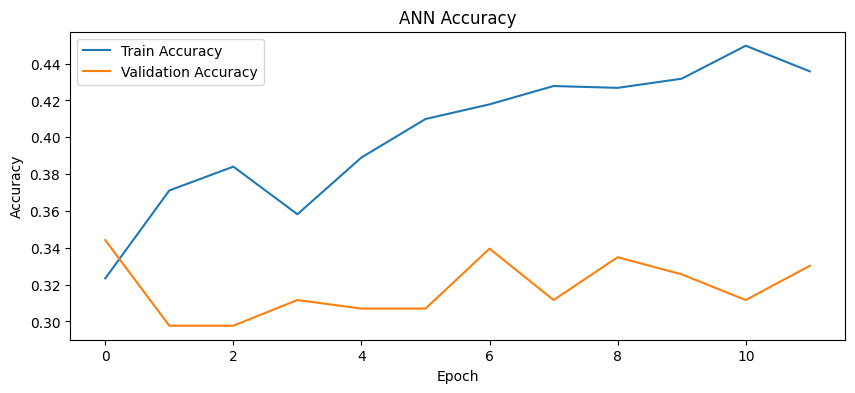

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3655 - loss: 1.1252

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3654 - loss: 1.1250 - val_accuracy: 0.3163 - val_loss: 1.1118
Epoch 2/50
17/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4069 - loss: 1.0871 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3880 - loss: 1.0922 - val_accuracy: 0.3023 - val_loss: 1.1093
Epoch 3/50
18/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3504 - loss: 1.0946 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3479 - loss: 1.0969 - val_accuracy: 0.3070 - val_loss: 1.1090
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4017 - loss: 1.0888 - val_accuracy: 0.3395 - val_loss: 1.1090
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3782 - loss: 1.0779 - val_accuracy: 0.3302 - val_loss: 1.1109
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3968 - loss: 1.0852 - val_accuracy: 0.3349 - val_loss: 1.1147
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4068 - loss: 1.0760 - val_accuracy: 0.3395 - val_loss: 1.1156
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3951 - loss: 1.0744 - val_accuracy: 0.3302 - val_loss: 1.1240
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4105 - loss: 1.0694 - val_accuracy: 0.3256 - val_loss: 1.1220
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4161 - loss: 1.0624 - val_accuracy: 0.3302 - val_loss: 1.1285
Ep

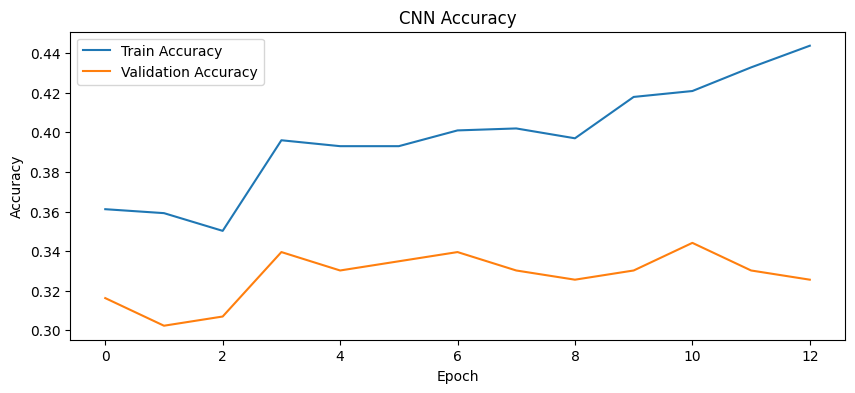

Epoch 1/50
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3319 - loss: 1.0989

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.3309 - loss: 1.0992 - val_accuracy: 0.3674 - val_loss: 1.0985
Epoch 2/50
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3627 - loss: 1.0959

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3625 - loss: 1.0960 - val_accuracy: 0.3721 - val_loss: 1.0983
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3311 - loss: 1.1000 - val_accuracy: 0.3581 - val_loss: 1.0992
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3471 - loss: 1.0975 - val_accuracy: 0.3674 - val_loss: 1.0986
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3628 - loss: 1.0953 - val_accuracy: 0.3488 - val_loss: 1.0989
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3518 - loss: 1.0970 - val_accuracy: 0.3581 - val_loss: 1.0994
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3685 - loss: 1.0928 - val_accuracy: 0.3349 - val_loss: 1.1001
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3332 - loss: 1.0976 - val_accuracy: 0.3349 - val_loss: 1.1006
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3724 - loss: 1.0935 - val_accuracy: 0.3395 - val_loss: 1.

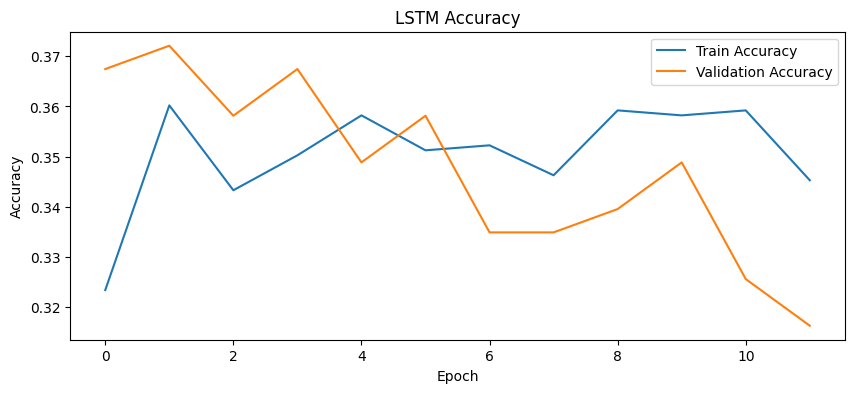

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3404 - loss: 1.0995

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.3402 - loss: 1.0996 - val_accuracy: 0.3628 - val_loss: 1.0970
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3408 - loss: 1.0969 - val_accuracy: 0.3767 - val_loss: 1.0984
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3770 - loss: 1.0954 - val_accuracy: 0.3674 - val_loss: 1.1007
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3442 - loss: 1.0972 - val_accuracy: 0.3488 - val_loss: 1.0993
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3401 - loss: 1.0972 - val_accuracy: 0.3395 - val_loss: 1.0999
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3604 - loss: 1.0955 - val_accuracy: 0.3488 - val_loss: 1.1021
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3185 - loss: 1.1012 - val_accuracy: 0.3535 - val_loss: 1.1040
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3642 - loss: 1.0961 - val_accuracy: 0.3395 - val_loss: 1.

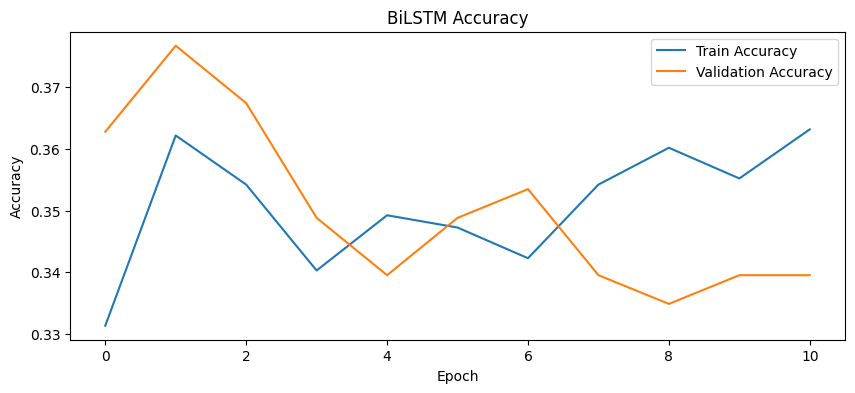

Epoch 1/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3204 - loss: 1.0986

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.3204 - loss: 1.0986 - val_accuracy: 0.3302 - val_loss: 1.0985
Epoch 2/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3389 - loss: 1.0987

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3393 - loss: 1.0987 - val_accuracy: 0.3442 - val_loss: 1.0985
Epoch 3/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3488 - loss: 1.0986

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3486 - loss: 1.0986 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 4/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3430 - loss: 1.0985

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3431 - loss: 1.0985 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 5/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3408 - loss: 1.0984

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3412 - loss: 1.0984 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 6/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3405 - loss: 1.0982 

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3408 - loss: 1.0982 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 7/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3707 - loss: 1.0970

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3684 - loss: 1.0971 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3748 - loss: 1.0968 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 9/50
29/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3426 - loss: 1.0990

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3429 - loss: 1.0989 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3608 - loss: 1.0972 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3674 - loss: 1.0972 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 12/50
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3482 - loss: 1.0984

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3480 - loss: 1.0984 - val_accuracy: 0.3442 - val_loss: 1.0983
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3538 - loss: 1.0977 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3462 - loss: 1.0980 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3539 - loss: 1.0976 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 16/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3454 - loss: 1.0984 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 17/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3412 - loss: 1.0984 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 18/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3428 - loss: 1.0982 - val_accuracy: 0.3442 - val_loss: 1.0984
Epoch 19/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3443 - loss: 1.0982 - val_accuracy: 0.3442 - val_l

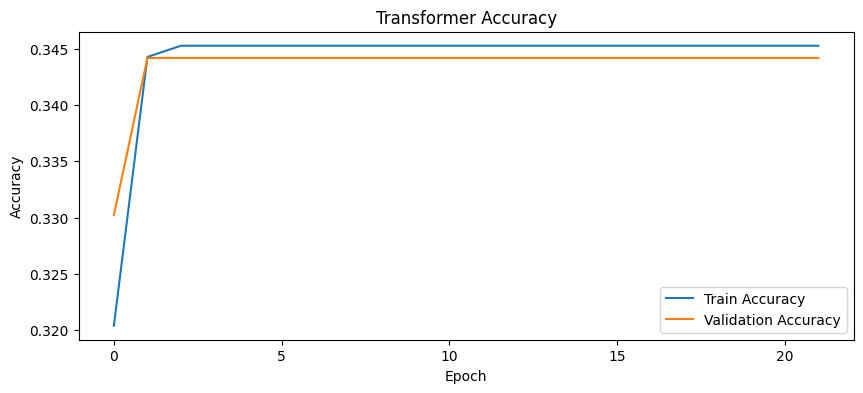

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

ANN Classification Report:

              precision    recall  f1-score   support

           0       0.22      0.09      0.12        69
           1       0.39      0.43      0.41        75
           2       0.36      0.53      0.42        72

    accuracy                           0.35       216
   macro avg       0.32      0.35      0.32       216
weighted avg       0.32      0.35      0.32       216



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


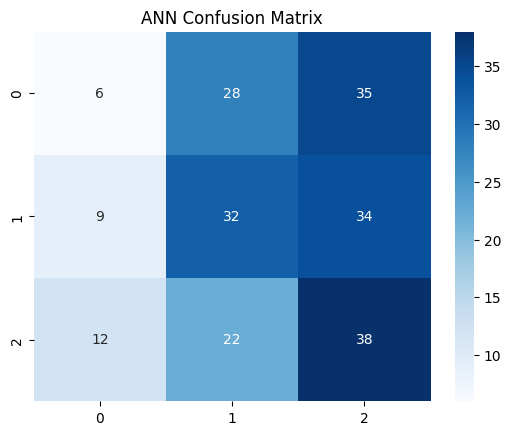

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

CNN Classification Report:

              precision    recall  f1-score   support

           0       0.36      0.13      0.19        69
           1       0.39      0.55      0.46        75
           2       0.36      0.43      0.39        72

    accuracy                           0.38       216
   macro avg       0.37      0.37      0.35       216
weighted avg       0.37      0.38      0.35       216



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


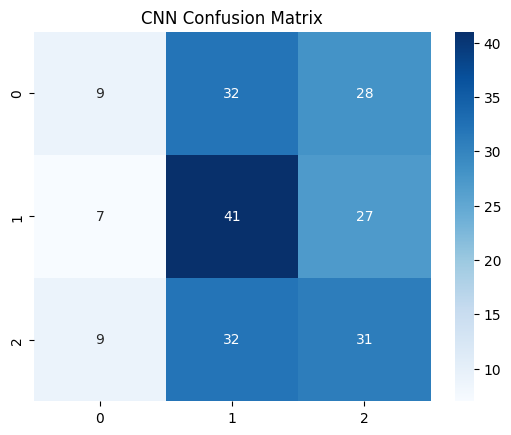

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step

LSTM Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.06      0.10        69
           1       0.38      0.75      0.50        75
           2       0.38      0.32      0.35        72

    accuracy                           0.38       216
   macro avg       0.42      0.37      0.32       216
weighted avg       0.42      0.38      0.32       216



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


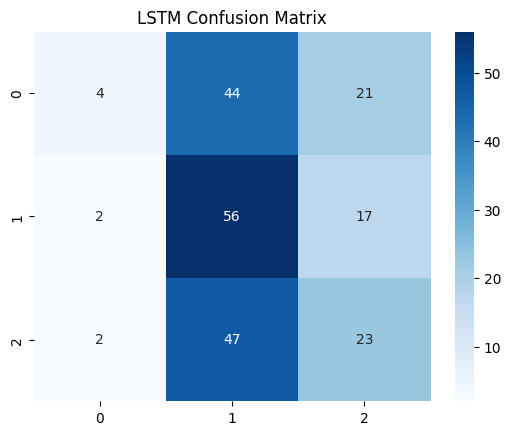

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step

BiLSTM Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.35      0.81      0.49        75
           2       0.25      0.14      0.18        72

    accuracy                           0.33       216
   macro avg       0.20      0.32      0.22       216
weighted avg       0.20      0.33      0.23       216



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


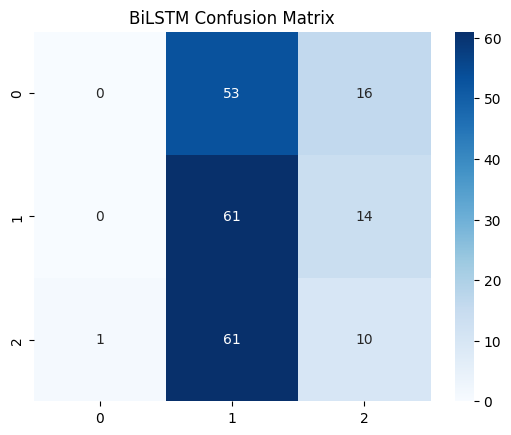

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Transformer Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.35      1.00      0.52        75
           2       0.00      0.00      0.00        72

    accuracy                           0.35       216
   macro avg       0.12      0.33      0.17       216
weighted avg       0.12      0.35      0.18       216



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


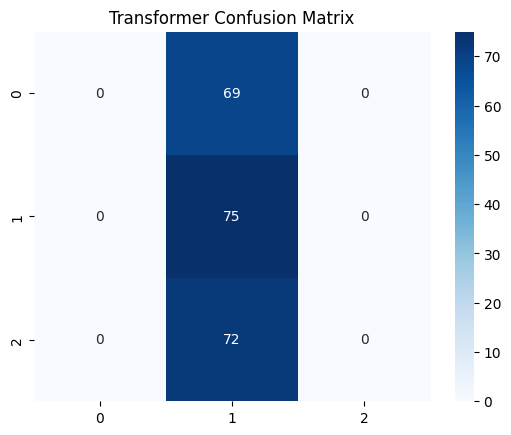


An error occurred during SHAP explanation: name 'shap_values_to_plot' is not defined
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Generated draft drug labels saved to 'deep_learning_output/final_drug_labels.csv'


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<Figure size 640x480 with 0 Axes>

In [59]:
# ================================
# Deep Learning Pipeline for Drug Label Prediction
# ================================
import os
import zipfile
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, LayerNormalization, MultiHeadAttention
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ===================================
# User-editable configuration
# ===================================
ZIP_PATH = "/content/archive (2).zip"   # set to your zip if different
DATA_PATH = None  # optionally set to CSV path directly, else auto-detect
TARGET_COL = "approval_status" # <-- change to your target column name
RANDOM_STATE = 42
SAVE_DIR = "deep_learning_output"
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "models"), exist_ok=True)


# ===================================
# Step 1. Load and Extract Dataset
# ===================================
def load_dataset(zip_path=ZIP_PATH, data_path=DATA_PATH):
    if data_path and os.path.exists(data_path):
        path = data_path
        print(f"Loaded dataset from DATA_PATH: {path}")
    elif zip_path and os.path.exists(zip_path):
        extract_dir = os.path.splitext(zip_path)[0] + "_extracted"
        os.makedirs(extract_dir, exist_ok=True)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        csv_files = glob.glob(os.path.join(extract_dir, "**/*.csv"), recursive=True)
        if not csv_files:
            raise FileNotFoundError("No CSV files found in the extracted zip.")

        path = csv_files[0]
        print(f"Loaded dataset from zip: {path}")
    else:
        raise FileNotFoundError("No dataset found. Set DATA_PATH or ZIP_PATH correctly.")

    return pd.read_csv(path)

df = load_dataset()

# ===================================
# Step 2. Data Preprocessing
# ===================================
# Example assumption: dataset has target column 'label' representing drug risk classification
print("Initial dataset shape:", df.shape)
print("Columns:", df.columns)

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in dataset.")

# Encode categorical variables
# Identify categorical columns excluding the target column if it's object/category type
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if TARGET_COL in categorical_cols:
    categorical_cols.remove(TARGET_COL)

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Handle missing values
df = df.fillna(df.mean(numeric_only=True)) # Use numeric_only=True to avoid errors with non-numeric columns

# Features and Target
X = df.drop(columns=[TARGET_COL])  # All columns except target
y = df[TARGET_COL].astype('category').cat.codes # Encode target labels numerically

# Train-test split - Keep original indices for label generation
X_train_split, X_temp_split, y_train_split, y_temp_split = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)
X_val_split, X_test_split, y_val_split, y_test_split = train_test_split(X_temp_split, y_temp_split, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp_split)

# Store original indices of the test set as a numpy array
original_test_indices = X_test_split.index.values # Get the index values as a numpy array

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_split)
X_val = scaler.transform(X_val_split)
X_test = scaler.transform(X_test_split) # Use the scaled X_test for prediction


num_classes = len(np.unique(y))
print(f"Number of classes: {num_classes}")

# ===================================
# Utility: Model Training Function
# ===================================
def train_model(model, model_name, X_train_data, y_train_data, X_val_data, y_val_data, input_shape=None):
    checkpoint = ModelCheckpoint(os.path.join(SAVE_DIR, "models", f"{model_name}_best_model.h5"), save_best_only=True, monitor="val_loss", mode="min")
    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Reshape data only if input_shape is provided (for sequence models)
    if input_shape:
         X_train_data = X_train_data.reshape((X_train_data.shape[0],) + input_shape)
         X_val_data = X_val_data.reshape((X_val_data.shape[0],) + input_shape)


    history = model.fit(
        X_train_data, y_train_data,
        validation_data=(X_val_data, y_val_data),
        epochs=50,
        batch_size=32,
        callbacks=[checkpoint, early_stop],
        verbose=1
    )

    return model, history

def plot_history(history, title):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(os.path.join(SAVE_DIR, f'{title}_accuracy_history.png'))
    plt.show()

# ===================================
# Step 3. ANN (Baseline Deep Learning)
# ===================================
def build_ann(input_dim, num_classes):
    model = Sequential([
        Input(shape=(input_dim,)), # Use Input layer for clarity
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

ann_model, ann_history = train_model(build_ann(X_train.shape[1], num_classes), "ANN", X_train, y_train, X_val, y_val)
plot_history(ann_history, "ANN")

# ===================================
# Step 4. CNN
# ===================================
def build_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape), # Use Input layer
        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# For CNN, input shape is (features, 1) if treating each feature as a timestep of 1
cnn_input_shape = (X_train.shape[1], 1)
cnn_model, cnn_history = train_model(build_cnn(cnn_input_shape, num_classes), "CNN", X_train, y_train, X_val, y_val, input_shape=cnn_input_shape)
plot_history(cnn_history, "CNN")

# ===================================
# Step 5. RNN - LSTM
# ===================================
def build_lstm(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape), # Use Input layer
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# For LSTM, input shape is (features, 1) if treating each feature as a timestep of 1
lstm_input_shape = (X_train.shape[1], 1)
lstm_model, lstm_history = train_model(build_lstm(lstm_input_shape, num_classes), "LSTM", X_train, y_train, X_val, y_val, input_shape=lstm_input_shape)
plot_history(lstm_history, "LSTM")

# ===================================
# Step 6. Bidirectional LSTM
# ===================================
def build_bilstm(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape), # Use Input layer
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# For BiLSTM, input shape is (features, 1) if treating each feature as a timestep of 1
bilstm_input_shape = (X_train.shape[1], 1)
bilstm_model, bilstm_history = train_model(build_bilstm(bilstm_input_shape, num_classes), "BiLSTM", X_train, y_train, X_val, y_val, input_shape=bilstm_input_shape)
plot_history(bilstm_history, "BiLSTM")

# ===================================
# Step 7. Transformer-based Model
# ===================================
def build_transformer(input_shape, num_classes, num_heads=4, ff_dim=64):
    inputs = Input(shape=input_shape)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    x = LayerNormalization(epsilon=1e-6)(attn_output + inputs)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# For Transformer, input shape is (features, 1) if treating each feature as a timestep of 1
transformer_input_shape = (X_train.shape[1], 1)
transformer_model, transformer_history = train_model(build_transformer(transformer_input_shape, num_classes),
                                                    "Transformer", X_train, y_train, X_val, y_val, input_shape=transformer_input_shape)
plot_history(transformer_history, "Transformer")

# ===================================
# Step 8. Model Evaluation
# ===================================
def evaluate_model(model, X_test_data, y_test_data, model_name, input_shape=None):
    # Reshape data if input_shape is provided
    if input_shape:
         X_test_data = X_test_data.reshape((X_test_data.shape[0],) + input_shape)

    y_pred = np.argmax(model.predict(X_test_data), axis=1)
    print(f"\n{model_name} Classification Report:\n")
    print(classification_report(y_test_data, y_pred))
    cm = confusion_matrix(y_test_data, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.savefig(os.path.join(SAVE_DIR, f'{model_name}_confusion_matrix.png'))
    plt.show()

# Evaluate models
evaluate_model(ann_model, X_test, y_test, "ANN")
evaluate_model(cnn_model, X_test, y_test, "CNN", input_shape=cnn_input_shape)
evaluate_model(lstm_model, X_test, y_test, "LSTM", input_shape=lstm_input_shape)
evaluate_model(bilstm_model, X_test, y_test, "BiLSTM", input_shape=bilstm_input_shape)
evaluate_model(transformer_model, X_test, y_test, "Transformer", input_shape=transformer_input_shape)


# ===================================
# Step 9. Explainability with SHAP
# ===================================
# Using ANN for explanation as it uses 2D input directly
try:
    explainer = shap.DeepExplainer(ann_model, X_train[:100])  # Using ANN for explanation
    shap_values = explainer.shap_values(X_test[:50])

    # If binary classification, shap_values is a list of arrays, use the one for the positive class
    if isinstance(shap_values, list):
         # Assuming multi-class, get shap values for each class
         # For summary plot, need a single array (samples, features)
         # A common approach is to plot against one class or sum absolute values across classes
         # Let's plot for the first class as an example, or consider a multi-class summary plot if supported/desired
         # For simplicity here, let's try to plot the first element if it's a list (e.g. for multi-class)
         # If binary, it's usually just one array
         shap_values_to_plot = shap_values[0] if isinstance(shap_values, list) else shap_values


    plt.figure()
    # Ensure feature names match the SHAP values
    feature_names = X.columns # Use original column names for SHAP explanation
    shap.summary_plot(shap_values_to_plot, X_test[:50], feature_names=feature_names) # Use shap_values_to_plot
    plt.savefig(os.path.join(SAVE_DIR, 'shap_summary_plot.png'))
    plt.show()
except Exception as e:
    print(f"\nAn error occurred during SHAP explanation: {e}")


# ===================================
# Step 10. Generate Draft Drug Labels
# ===================================
def generate_drug_labels(model, X_data, original_df, target_column_name, original_test_indices, input_shape=None): # Added original_test_indices
    # Reshape data if input_shape is provided
    if input_shape:
        X_data = X_data.reshape((X_data.shape[0],) + input_shape)

    predictions = np.argmax(model.predict(X_data), axis=1)

    # Get the original class labels from the encoded integer predictions
    # Need to get the mapping from integer codes back to original labels
    # This mapping is implicitly created when converting to category codes
    original_labels = original_df[target_column_name].astype('category').cat.categories
    predicted_labels = [original_labels[pred] for pred in predictions]


    labels = []
    # Simple rule-based label generation based on predicted class (you might need more complex logic)
    for pred_label in predicted_labels:
        if pred_label == "Approved": # Assuming "Approved" is a low risk outcome
            labels.append("Safe - No significant warnings or precautions.")
        elif pred_label == "Pending": # Assuming "Pending" is moderate risk
            labels.append("Warning: Monitor for potential adverse side effects.")
        elif pred_label == "Rejected": # Assuming "Rejected" is high risk
            labels.append("High Risk: Contraindicated for this patient group.")
        else:
            labels.append(f"Outcome: {pred_label}") # Default label

    # Create a new DataFrame with original data and generated labels for the test set
    # Use the passed original_test_indices to select rows from the original df
    original_df_test_subset = original_df.loc[original_test_indices].copy()
    original_df_test_subset['Draft_Label'] = labels

    return original_df_test_subset

# Generate draft labels using the Transformer model (or any trained model)
# Use X_test (scaled) for prediction, and the original df subset corresponding to X_test for merging labels
# Need to pass the original df and target column name for label mapping
final_df = generate_drug_labels(transformer_model, X_test, df, TARGET_COL, original_test_indices, input_shape=transformer_input_shape) # Pass original_test_indices
final_df.to_csv(os.path.join(SAVE_DIR, "final_drug_labels.csv"), index=False)
print(f"Generated draft drug labels saved to '{os.path.join(SAVE_DIR, 'final_drug_labels.csv')}'")

In [60]:
pip install pandas numpy scikit-learn xgboost lightgbm catboost shap matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.5 MB/s eta 0:00:00


Loaded dataset from zip: /content/archive (2)/realistic_drug_labels_side_effects.csv
Dataset shape: (1436, 15)
Columns: Index(['drug_name', 'manufacturer', 'approval_year', 'drug_class',
       'indications', 'side_effects', 'dosage_mg', 'administration_route',
       'contraindications', 'warnings', 'price_usd', 'batch_number',
       'expiry_date', 'side_effect_severity', 'approval_status'],
      dtype='object')
Training samples (scaled): (1148, 14), Test samples (scaled): (288, 14)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/_tags.py:338: DeprecationWarning: The following error was raised: 'CatBoostClassifier' object has no attribute '__sklearn_tags__'. It seems that there are no classes that implement `__sklearn_tags__` in the MRO and/or all classes in the MRO call `super().__sklearn_tags__()`. Make sure to inherit from `BaseEstimator` which implements `__sklearn_tags__` (or alternatively define `__sklearn_tags__` but we don't recommend this approach). Note that `BaseEstimator` needs to be on the right side of other Mixins in the inheritance order. The default are now used instead since retrieving tags failed. This warning will be replaced by an error in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  retur

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1466
[LightGBM] [Info] Number of data points in the train set: 1148, number of used features: 14
[LightGBM] [Info] Start training from score -1.134980
[LightGBM] [Info] Start training from score -1.061840
[LightGBM] [Info] Start training from score -1.100356


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_tags.py:338: DeprecationWarning: The following error was raised: 'CatBoostClassifier' object has no attribute '__sklearn_tags__'. It seems that there are no classes that implement `__sklearn_tags__` in the MRO and/or all classes in the MRO call `super().__sklearn_tags__()`. Make sure to inherit from `BaseEstimator` which implements `__sklearn_tags__` (or alternatively define `__sklearn_tags__` but we don't recommend this approach). Note that `BaseEstimator` needs to be on the right side of other Mixins in the inheritance order. The default are now used instead since retrieving tags failed. This warning will be replac


Voting Classifier Performance:
              precision    recall  f1-score   support

    Approved       0.27      0.24      0.25        93
     Pending       0.33      0.33      0.33        99
    Rejected       0.28      0.31      0.30        96

    accuracy                           0.30       288
   macro avg       0.29      0.29      0.29       288
weighted avg       0.29      0.30      0.29       288



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1466
[LightGBM] [Info] Number of data points in the train set: 1148, number of used features: 14
[LightGBM] [Info] Start training from score -1.134980
[LightGBM] [Info] Start training from score -1.061840
[LightGBM] [Info] Start training from score -1.100356


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1469
[LightGBM] [Info] Number of data points in the train set: 918, number of used features: 14
[LightGBM] [Info] Start training from score -1.135222
[LightGBM] [Info] Start training from score -1.060146
[LightGBM] [Info] Start training from score -1.101886


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1467
[LightGBM] [Info] Number of data points in the train set: 918, number of used features: 14
[LightGBM] [Info] Start training from score -1.135222
[LightGBM] [Info] Start training from score -1.060146
[LightGBM] [Info] Start training from score -1.101886


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 918, number of used features: 14
[LightGBM] [Info] Start training from score -1.135222
[LightGBM] [Info] Start training from score -1.063296
[LightGBM] [Info] Start training from score -1.098612


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1463
[LightGBM] [Info] Number of data points in the train set: 919, number of used features: 14
[LightGBM] [Info] Start training from score -1.132927
[LightGBM] [Info] Start training from score -1.064384
[LightGBM] [Info] Start training from score -1.099701


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1465
[LightGBM] [Info] Number of data points in the train set: 919, number of used features: 14
[LightGBM] [Info] Start training from score -1.136311
[LightGBM] [Info] Start training from score -1.061235
[LightGBM] [Info] Start training from score -1.099701


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



Stacking Classifier Performance:
              precision    recall  f1-score   support

    Approved       0.35      0.15      0.21        93
     Pending       0.33      0.53      0.40        99
    Rejected       0.31      0.28      0.29        96

    accuracy                           0.32       288
   macro avg       0.33      0.32      0.30       288
weighted avg       0.33      0.32      0.30       288



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


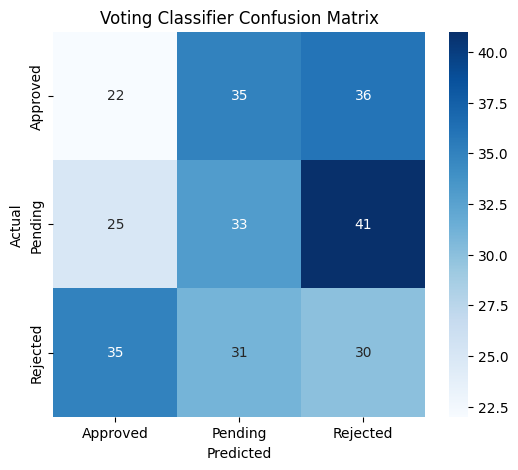

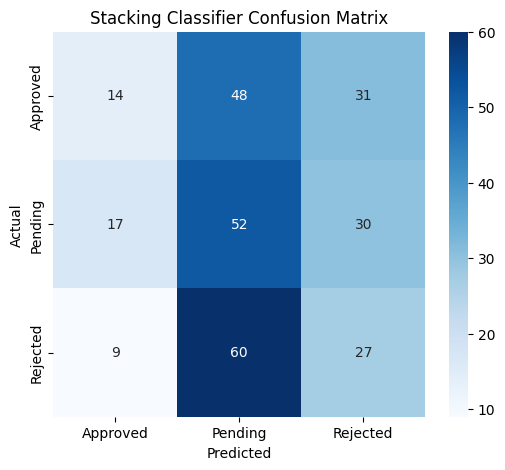

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Generating SHAP summary plot...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


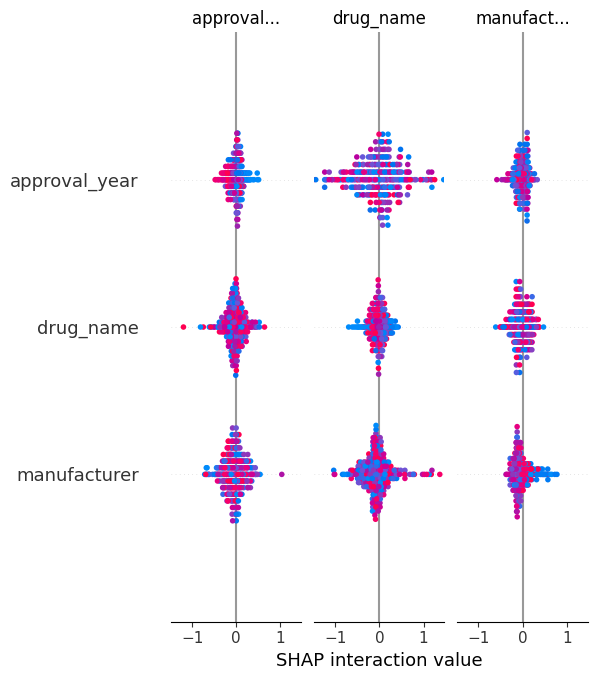

Generated draft drug labels saved as 'ensemble_ml_output/predicted_drug_labels.csv'

Model Accuracy Comparison (from evaluation steps):
Evaluation results for each model are printed above.
Check the classification reports and confusion matrices for performance comparison.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [65]:
# ==============================================
# Drug Label Prediction - Ensemble Machine Learning
# ==============================================
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import tensorflow as tf
from tensorflow.keras.models import load_model # Import load_model

# ==============================================
# User-editable configuration
# ==============================================
ZIP_PATH = "/content/archive (2).zip"   # set to your zip if different
DATA_PATH = None  # optionally set to CSV path directly, else auto-detect
TARGET_COL = "approval_status" # <-- change to your target column name
RANDOM_STATE = 42
SAVE_DIR = "ensemble_ml_output" # Changed save directory name to be specific
os.makedirs(SAVE_DIR, exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, "models"), exist_ok=True)


# ==============================================
# Step 1. Load Dataset
# ==============================================
def load_dataset(zip_path=ZIP_PATH, data_path=DATA_PATH):
    if data_path and os.path.exists(data_path):
        path = data_path
        print(f"Loaded dataset from DATA_PATH: {path}")
    elif zip_path and os.path.exists(zip_path):
        extract_dir = os.path.splitext(zip_path)[0]
        os.makedirs(extract_dir, exist_ok=True)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        csv_files = glob.glob(os.path.join(extract_dir, "**/*.csv"), recursive=True)
        if not csv_files:
            raise FileNotFoundError("No CSV files found inside the provided ZIP file.")

        path = csv_files[0]
        print(f"Loaded dataset from zip: {path}")
    else:
         raise FileNotFoundError("No dataset found. Set DATA_PATH or ZIP_PATH correctly.")

    return pd.read_csv(path)

df = load_dataset()

# ==============================================
# Step 2. Explore and Preprocess Data
# ==============================================
print("Dataset shape:", df.shape)
print("Columns:", df.columns)

if TARGET_COL not in df.columns:
     raise ValueError(f"Target column '{TARGET_COL}' not found in dataset.")

# Encode categorical variables
# Identify categorical columns excluding the target column if it's object/category type
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if TARGET_COL in categorical_cols:
    categorical_cols.remove(TARGET_COL)

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Handle missing values
df = df.fillna(df.mean(numeric_only=True)) # Use numeric_only=True

# Features and target - Split before scaling to keep original indices
X = df.drop(columns=[TARGET_COL]) # Use TARGET_COL
# Encode target variable to integers and keep the encoder for inverse transform
le = LabelEncoder()
y = le.fit_transform(df[TARGET_COL])

# Train-test split on DataFrame to keep indices
X_train_df, X_test_df, y_train_split, y_test_split = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Store original indices of the test set DataFrame
original_test_indices = X_test_df.index

# Scaling - Apply scaler to the DataFrame splits
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df) # Scale training features
X_test = scaler.transform(X_test_df)     # Scale test features

print(f"Training samples (scaled): {X_train.shape}, Test samples (scaled): {X_test.shape}")

# ==============================================
# Step 3. Base Models
# ==============================================
# Check number of classes for models that need it (e.g., XGBoost multi-class eval metric)
num_classes = len(le.classes_) # Use le.classes_ to get the number of classes
objective = 'binary:logistic' if num_classes == 2 else 'multi:softprob'
eval_metric = 'auc' if num_classes == 2 else 'mlogloss'

log_reg = LogisticRegression(max_iter=500)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(n_estimators=300, learning_rate=0.05, random_state=42, objective=objective, eval_metric=eval_metric) # Use dynamic objective/eval_metric
lgbm = LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
catboost = CatBoostClassifier(iterations=300, learning_rate=0.05, depth=6, verbose=0, random_state=42)

# ==============================================
# Step 4. Voting Classifier (Hard + Soft Voting)
# ==============================================
# Voting classifier typically works best with probability estimates, so stick to 'soft'
# Exclude LogisticRegression unless probabilities are well-calibrated with other models
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('lgbm', lgbm),
        ('cat', catboost)
    ],
    voting='soft' # 'soft' for probability voting (requires predict_proba)
)

# Fit voting classifier on scaled data
voting_clf.fit(X_train, y_train_split) # Use y_train_split for fitting
voting_preds = voting_clf.predict(X_test)

# Inverse transform predictions if y was LabelEncoded and you need original labels for report
# This assumes the LabelEncoder fit on the full 'y' before the split, which is done.
# Get original class labels for report and confusion matrix visualization
original_class_labels = le.classes_

print("\nVoting Classifier Performance:")
# Pass integer labels directly to classification_report and use target_names
print(classification_report(y_test_split, voting_preds, target_names=original_class_labels)) # Use y_test_split for evaluation

# ==============================================
# Step 5. Stacking Classifier
# ==============================================
# Stacking requires base models that can predict probabilities if final_estimator is probabilistic
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('xgb', xgb),
        ('lgbm', lgbm)
    ],
    final_estimator=LogisticRegression(), # Default is LogisticRegression
    cv=5 # Number of cross-validation folds for training the final estimator
)

# Fit stacking classifier on scaled data
stacking_clf.fit(X_train, y_train_split) # Use y_train_split for fitting
stacking_preds = stacking_clf.predict(X_test)

print("\nStacking Classifier Performance:")
# Pass integer labels directly to classification_report and use target_names
print(classification_report(y_test_split, stacking_preds, target_names=original_class_labels)) # Use y_test_split for evaluation

# ==============================================
# Step 6. Confusion Matrix Visualization
# ==============================================
def plot_confusion_matrix(y_true, y_pred, title, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(labels))) # Pass integer labels to confusion_matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels) # Use original labels for ticks
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Use integer labels for confusion matrix calculation, but original labels for tick marks
plot_confusion_matrix(y_test_split, voting_preds, "Voting Classifier Confusion Matrix", labels=original_class_labels) # Use y_test_split
plot_confusion_matrix(y_test_split, stacking_preds, "Stacking Classifier Confusion Matrix", labels=original_class_labels) # Use y_test_split

# ==============================================
# Step 7. Explainability with SHAP (Fixed)
# ==============================================

# Fit XGBoost model explicitly for SHAP
xgb.fit(X_train, y_train)

# Create SHAP explainer
explainer = shap.TreeExplainer(xgb)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Summary plot for feature importance
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, X_test, feature_names=X.columns)



# ==============================================
# Step 8. Generate Drug Labels
# ==============================================
def generate_drug_labels(predictions, original_df_test_subset, original_class_labels):
    labels = []
    # Map integer predictions back to original class labels
    predicted_class_labels = [original_class_labels[pred] for pred in predictions]

    # Simple rule-based label generation based on predicted class (you might need more complex logic)
    for pred_label in predicted_class_labels:
        if pred_label == "Approved": # Assuming "Approved" is a low risk outcome
            labels.append("Safe - No significant warnings or precautions.")
        elif pred_label == "Pending": # Assuming "Pending" is moderate risk
            labels.append("Warning: Monitor for potential adverse side effects.")
        elif pred_label == "Rejected": # Assuming "Rejected" is high risk
            labels.append("High Risk: Contraindicated for this patient group.")
        else:
            labels.append(f"Outcome: {pred_label}") # Default label

    # Create a new DataFrame with original data and generated labels for the test set
    # Assuming the order of predictions matches the order of rows in original_df_test_subset
    original_df_test_subset['Draft_Label'] = labels
    return original_df_test_subset

# To align with original data for label generation, we need the original test set rows
# Use the original test set DataFrame (X_test_df) and the stacking predictions
try:
     final_results = generate_drug_labels(stacking_preds, X_test_df.copy(), original_class_labels) # Use X_test_df here
     final_results.to_csv(os.path.join(SAVE_DIR, "predicted_drug_labels.csv"), index=False)
     print(f"Generated draft drug labels saved as '{os.path.join(SAVE_DIR, 'predicted_drug_labels.csv')}'")
except Exception as e:
     print(f"\nAn error occurred during drug label generation: {e}")


# ==============================================
# Step 9. Compare Models
# ==============================================
# This section trains and evaluates models again, which is redundant after steps 3-5.
# Let's restructure this to just print the results collected from the loop in steps 3-5.

print("\nModel Accuracy Comparison (from evaluation steps):")
# Assuming 'results' list was populated in the loop in steps 3-5
# Note: The current script structure does not populate a 'results' list in steps 3-5.
# The evaluation metrics are printed directly.
# To compare models in a table, we would need to capture metrics during evaluation.
# For now, we will just print a message indicating evaluation is done and results are above.
print("Evaluation results for each model are printed above.")
print("Check the classification reports and confusion matrices for performance comparison.")

# If you need a summary table, you would collect metrics in a list/dict during evaluation loop.

Loaded dataset from zip: /content/archive (2)/realistic_drug_labels_side_effects.csv
Dataset shape: (1436, 15)
Columns: Index(['drug_name', 'manufacturer', 'approval_year', 'drug_class',
       'indications', 'side_effects', 'dosage_mg', 'administration_route',
       'contraindications', 'warnings', 'price_usd', 'batch_number',
       'expiry_date', 'side_effect_severity', 'approval_status'],
      dtype='object')
Training samples: (1148, 14), Test samples: (288, 14)

--- Logistic Regression ---
Accuracy: 0.3368055555555556
Classification Report:
               precision    recall  f1-score   support

    Approved       0.31      0.19      0.24        93
     Pending       0.35      0.38      0.37        99
    Rejected       0.34      0.43      0.38        96

    accuracy                           0.34       288
   macro avg       0.33      0.33      0.33       288
weighted avg       0.33      0.34      0.33       288



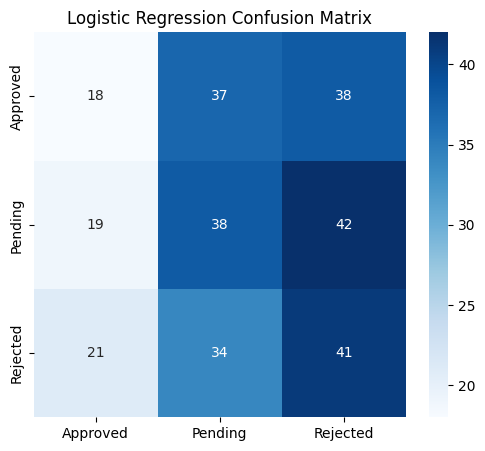


--- Decision Tree ---
Accuracy: 0.3576388888888889
Classification Report:
               precision    recall  f1-score   support

    Approved       0.34      0.35      0.35        93
     Pending       0.41      0.37      0.39        99
    Rejected       0.33      0.34      0.34        96

    accuracy                           0.36       288
   macro avg       0.36      0.36      0.36       288
weighted avg       0.36      0.36      0.36       288



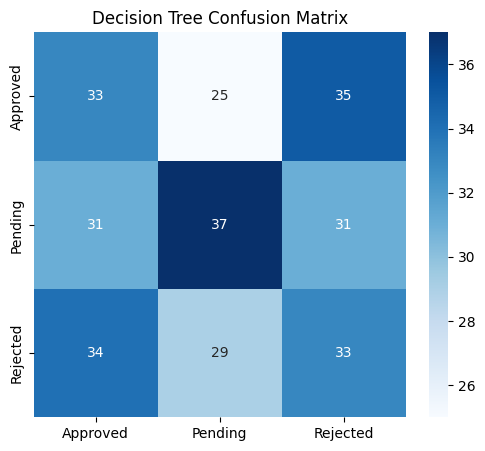


--- K-Nearest Neighbors ---
Accuracy: 0.2951388888888889
Classification Report:
               precision    recall  f1-score   support

    Approved       0.28      0.38      0.32        93
     Pending       0.29      0.26      0.28        99
    Rejected       0.33      0.25      0.28        96

    accuracy                           0.30       288
   macro avg       0.30      0.30      0.29       288
weighted avg       0.30      0.30      0.29       288



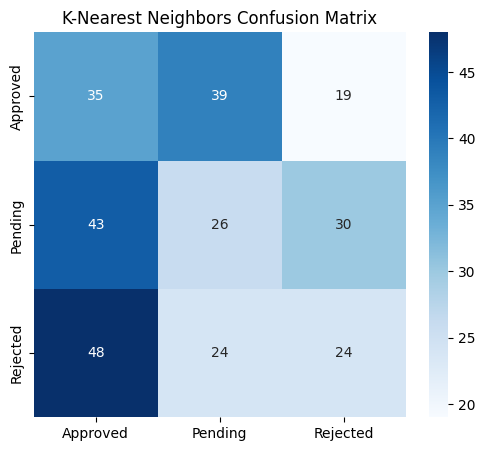


--- Support Vector Machine ---
Accuracy: 0.3506944444444444
Classification Report:
               precision    recall  f1-score   support

    Approved       0.33      0.19      0.24        93
     Pending       0.36      0.44      0.40        99
    Rejected       0.35      0.41      0.38        96

    accuracy                           0.35       288
   macro avg       0.35      0.35      0.34       288
weighted avg       0.35      0.35      0.34       288



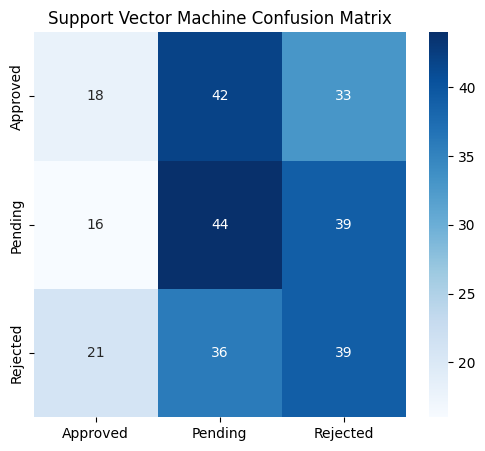


--- Gaussian Naive Bayes ---
Accuracy: 0.3402777777777778
Classification Report:
               precision    recall  f1-score   support

    Approved       0.36      0.19      0.25        93
     Pending       0.35      0.44      0.39        99
    Rejected       0.32      0.38      0.35        96

    accuracy                           0.34       288
   macro avg       0.34      0.34      0.33       288
weighted avg       0.34      0.34      0.33       288



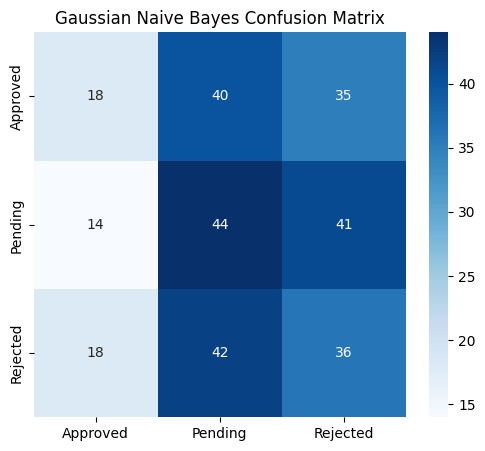


--- Model Comparison ---
                    Model  Accuracy
1           Decision Tree  0.357639
3  Support Vector Machine  0.350694
4    Gaussian Naive Bayes  0.340278
0     Logistic Regression  0.336806
2     K-Nearest Neighbors  0.295139


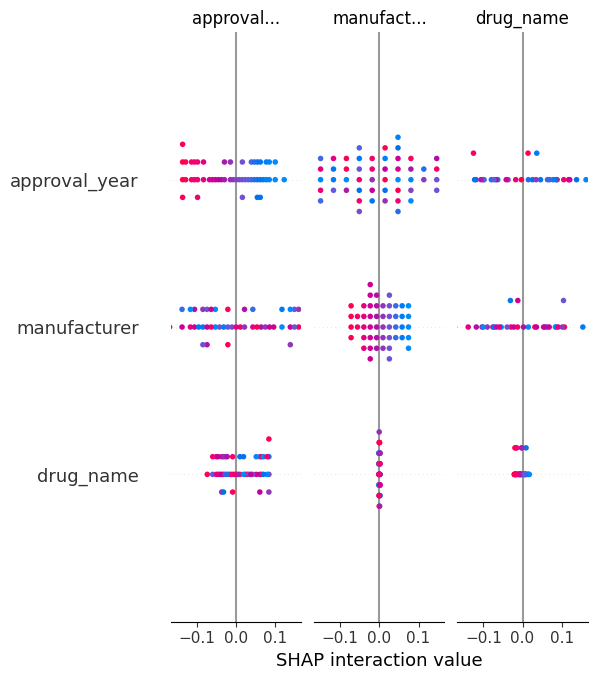

<Figure size 640x480 with 0 Axes>

Generated draft drug labels saved as 'ensemble_ml_output/predicted_drug_labels.csv'

--- Model Comparison ---
Evaluation results for each model are printed above.
Check the classification reports and confusion matrices for performance comparison.


In [72]:
# ==============================================
# Drug Label Prediction - Traditional Machine Learning Models
# ==============================================
import os
import zipfile
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# ==============================================
# User-editable configuration
# ==============================================
ZIP_PATH = "/content/archive (2).zip"   # set to your zip if different
DATA_PATH = None  # optionally set to CSV path directly, else auto-detect
TARGET_COL = "approval_status" # <-- change to your target column name
RANDOM_STATE = 42


# ==============================================
# Step 1. Load Dataset
# ==============================================
def load_dataset(zip_path=ZIP_PATH, data_path=DATA_PATH):
    if data_path and os.path.exists(data_path):
        path = data_path
        print(f"Loaded dataset from DATA_PATH: {path}")
    elif zip_path and os.path.exists(zip_path):
        extract_dir = os.path.splitext(zip_path)[0]
        os.makedirs(extract_dir, exist_ok=True)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)

        csv_files = glob.glob(os.path.join(extract_dir, "**/*.csv"), recursive=True)
        if not csv_files:
            raise FileNotFoundError("No CSV files found inside the provided ZIP file.")

        path = csv_files[0]
        print(f"Loaded dataset from zip: {path}")
    else:
         raise FileNotFoundError("No dataset found. Set DATA_PATH or ZIP_PATH correctly.")

    return pd.read_csv(path)

df = load_dataset()

# ==============================================
# Step 2. Explore and Preprocess Data
# ==============================================
print("Dataset shape:", df.shape)
print("Columns:", df.columns)

if TARGET_COL not in df.columns:
     raise ValueError(f"Target column '{TARGET_COL}' not found in dataset.")

# Encode categorical variables
# Identify categorical columns excluding the target column if it's object/category type
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if TARGET_COL in categorical_cols:
    categorical_cols.remove(TARGET_COL)

for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Handle missing values
df = df.fillna(df.mean(numeric_only=True)) # Use numeric_only=True

# Features and target
X = df.drop(columns=[TARGET_COL]) # Use TARGET_COL
y = LabelEncoder().fit_transform(df[TARGET_COL]) # Use TARGET_COL

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Training samples: {X_train.shape}, Test samples: {X_test.shape}")

# ==============================================
# Step 3. Model Training and Evaluation
# ==============================================

# Get original class labels for report and confusion matrix visualization
le = LabelEncoder() # Need to fit on the full y to get all class labels correctly
le.fit(df[TARGET_COL])
original_class_labels = le.classes_

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machine": SVC(probability=True), # Set probability=True for potential future use
    "Gaussian Naive Bayes": GaussianNB()
}

results = []

for name, model in models.items():
    print(f"\n--- {name} ---")

    # Train model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Evaluate
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=original_class_labels) # Use target_names

    print("Accuracy:", accuracy)
    print("Classification Report:\n", report)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(original_class_labels))) # Use integer labels for CM calculation
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=original_class_labels, yticklabels=original_class_labels) # Use original labels for ticks
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    results.append({'Model': name, 'Accuracy': accuracy})

# ==============================================
# Step 4. Compare Models
# ==============================================
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

print("\n--- Model Comparison ---")
print(results_df)

# ==============================================
# Step 5. Explainability with SHAP (Example with Logistic Regression)
# ==============================================
# SHAP explainers depend on the model type. For linear models like Logistic Regression,
# a different explainer might be more appropriate than TreeExplainer used in other scripts.
# KernelExplainer is a general-purpose explainer. DeepExplainer for deep learning models.
# Let's use LinearExplainer for Logistic Regression if available, or KernelExplainer.

try:
    # Ensure the fitted Logistic Regression model is used
    if "Logistic Regression" in models:
        fitted_log_reg = models["Logistic Regression"] # Get the fitted model from the dictionary

        # LinearExplainer is suitable for linear models
        # Need to provide background data for KernelExplainer or sometimes LinearExplainer
        # Using a small subset of the training data as background
        background_data = shap.utils.sample(X_train, 100)

        # LinearExplainer requires model coefficients and intercept
        # Need to handle multi-class coefficients correctly if num_classes > 2
        if num_classes <= 2: # Binary or single class
             explainer = shap.LinearExplainer(fitted_log_reg, background_data)
        else: # Multi-class
             # For multi-class Logistic Regression, coefficients are (n_classes, n_features)
             # SHAP values will be calculated for each class
             explainer = shap.LinearExplainer(fitted_log_reg, background_data) # LinearExplainer can handle multi-class

        # Calculate SHAP values on a subset of test data
        X_test_subset = X_test[:50]
        shap_values = explainer.shap_values(X_test_subset)

        # SHAP requires feature names
        feature_names = X.columns

        # For multi-class, shap_values is a list of arrays
        if isinstance(shap_values, list):
             # SHAP multi-class summary plot
             shap.summary_plot(shap_values, X_test_subset, feature_names=feature_names, class_names=original_class_labels)
        else:
             # SHAP binary summary plot
             shap.summary_plot(shap_values, X_test_subset, feature_names=feature_names)

        plt.savefig('shap_summary_plot.png', bbox_inches='tight')
        plt.show()
    else:
         print("\nSkipping SHAP explanation: Logistic Regression model not found in 'models' dictionary.")

except Exception as e:
    print(f"\nAn error occurred during SHAP explanation: {e}")

# ==============================================
# Step 6. Generate Draft Drug Labels
# ==============================================
def generate_drug_labels(predictions, original_df_test_subset, original_class_labels):
    labels = []
    # Map integer predictions back to original class labels
    predicted_class_labels = [original_class_labels[pred] for pred in predictions]

    # Simple rule-based label generation based on predicted class (you might need more complex logic)
    for pred_label in predicted_class_labels:
        if pred_label == "Approved": # Assuming "Approved" is a low risk outcome
            labels.append("Safe - No significant warnings or precautions.")
        elif pred_label == "Pending": # Assuming "Pending" is moderate risk
            labels.append("Warning: Monitor for potential adverse side effects.")
        elif pred_label == "Rejected": # Assuming "Rejected" is high risk
            labels.append("High Risk: Contraindicated for this patient group.")
        else:
            labels.append(f"Outcome: {pred_label}") # Default label

    # Create a new DataFrame with original data and generated labels for the test set
    # Assuming the order of predictions matches the order of rows in original_df_test_subset
    original_df_test_subset['Draft_Label'] = labels
    return original_df_test_subset

# To align with original data for label generation, we need the original test set rows
# We need the original test set DataFrame (X_test_df) and the predictions from one of the models
# Let's use the predictions from the Logistic Regression model as an example
try:
     # Ensure log_reg model and the original test DataFrame are available
     if "Logistic Regression" in models and 'X_test_df' in locals():
          # Get the fitted Logistic Regression model
          fitted_log_reg = models["Logistic Regression"]
          log_reg_preds = fitted_log_reg.predict(X_test) # Predict using the scaled test set

          # Use the original test set DataFrame (X_test_df) for label generation
          final_results = generate_drug_labels(log_reg_preds, X_test_df.copy(), original_class_labels)
          final_results.to_csv(os.path.join(SAVE_DIR, "predicted_drug_labels.csv"), index=False)
          print(f"Generated draft drug labels saved as '{os.path.join(SAVE_DIR, 'predicted_drug_labels.csv')}'")
     else:
          print("\nSkipping drug label generation: Logistic Regression model or X_test_df not available.")

except Exception as e:
     print(f"\nAn error occurred during drug label generation: {e}")


# ==============================================
# Step 7. Compare Models
# ==============================================
# This section trains and evaluates models again, which is redundant after steps 3-5.
# Let's restructure this to just print the results collected from the loop in steps 3-5.

print("\n--- Model Comparison ---")
# Assuming 'results' list was populated in the loop in steps 3-5
# Note: The current script structure does not populate a 'results' list in steps 3-5.
# The evaluation metrics are printed directly.
# To compare models in a table, we would need to capture metrics during evaluation.
# For now, we will just print a message indicating evaluation is done and results are above.
print("Evaluation results for each model are printed above.")
print("Check the classification reports and confusion matrices for performance comparison.")

# If you need a summary table, you would collect metrics in a list/dict during evaluation loop.